# MOBL Arms 4.1 OpenSim Model Analysis

**Model**: MOBL Arms 4.1 Upper Extremity  
**Tool**: GraphMechanics Package  
**Date**: August 7, 2025  

## Summary
Analysis of model structure and conversion to graph representation for biomechanical research.

**Model Contents**: 12 bodies, 26 DOF, 50 muscles → Graph: 12 nodes, 11 edges

## 1. Setup and Model Loading

In [81]:
import graphmechanics as gm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from torch_geometric.data import Data
import warnings
warnings.filterwarnings('ignore')

# Load model
osim_path = '/home/funsega/GraphMechanics/data/Arm_model/Model/4.1/MOBL_ARMS_41.osim'
model = gm.OpenSimModelParser(osim_path)

print(f"Loaded: {model.model_name}")
print(f"Bodies: {len(model.bodies)}, Joints: {len(model.joints)}")
print(f"Coordinates: {len(model.coordinates)}, Muscles: {len(model.muscles)}")

Successfully parsed OpenSim model: Right
  Bodies: 12
  Joints: 12
  Coordinates: 26
  Muscles: 50
Loaded: Right
Bodies: 12, Joints: 12
Coordinates: 26, Muscles: 50


## 2. Model Structure

In [82]:
# Model statistics and body properties
n_bodies = len(model.bodies)
n_joints = len(model.joints) 
n_coordinates = len(model.coordinates)
n_muscles = len(model.muscles)

print("Bodies and Properties:")
total_mass = 0
for body_name, body_info in model.bodies.items():
    mass = body_info.mass if hasattr(body_info, 'mass') and body_info.mass else 0.0
    body_type = "phantom" if "phant" in body_name.lower() else "physical"
    print(f"  {body_name}: {mass:.3f} kg ({body_type})")
    total_mass += mass

print(f"\nTotal mass: {total_mass:.3f} kg")
print(f"Physical bodies: {sum(1 for name in model.bodies if 'phant' not in name.lower())}")
print(f"Phantom bodies: {sum(1 for name in model.bodies if 'phant' in name.lower())}")

Bodies and Properties:
  thorax: 0.000 kg (physical)
  clavicle: 0.156 kg (physical)
  clavphant: 0.000 kg (phantom)
  scapula: 0.704 kg (physical)
  scapphant: 0.000 kg (phantom)
  humphant: 0.000 kg (phantom)
  humphant1: 0.000 kg (phantom)
  humerus: 1.998 kg (physical)
  ulna: 1.105 kg (physical)
  radius: 0.234 kg (physical)
  proximal_row: 0.000 kg (physical)
  hand: 0.582 kg (physical)

Total mass: 4.779 kg
Physical bodies: 8
Phantom bodies: 4


### 2.2 Body Segment Analysis

In [83]:
# Joint configuration
print("Joints and DOF:")
for joint_name, joint_info in model.joints.items():
    n_coords = len(joint_info.coordinates) if joint_info.coordinates else 0
    print(f"  {joint_name}: {joint_info.parent_body} → {joint_info.child_body} ({n_coords} DOF)")

# Kinematic chain
hierarchy = model.body_hierarchy
print(f"\nKinematic chain:")
chain = []
current = 'thorax_offset'
while current in hierarchy and hierarchy[current]:
    body_name = current.replace('_offset', '')
    if body_name in model.bodies:
        chain.append(body_name)
    current = hierarchy[current][0] if hierarchy[current] else None

print(" → ".join(chain))

Joints and DOF:
  groundthorax: ground_offset → thorax_offset (6 DOF)
  sternoclavicular: thorax_offset → clavicle_offset (2 DOF)
  unrotscap: clavicle_offset → clavphant_offset (2 DOF)
  acromioclavicular: clavphant_offset → scapula_offset (3 DOF)
  unrothum: scapula_offset → scapphant_offset (3 DOF)
  shoulder0: scapphant_offset → humphant_offset (1 DOF)
  shoulder1: humphant_offset → humphant1_offset (2 DOF)
  shoulder2: humphant1_offset → humerus_offset (1 DOF)
  elbow: humerus_offset → ulna_offset (1 DOF)
  radioulnar: ulna_offset → radius_offset (1 DOF)
  radiocarpal: radius_offset → proximal_row_offset (2 DOF)
  wrist_hand: proximal_row_offset → hand_offset (2 DOF)

Kinematic chain:
thorax → clavicle → clavphant → scapula → scapphant → humphant → humphant1 → humerus → ulna → radius → proximal_row


In [84]:
# Muscle count by region (simplified classification)
muscle_names = list(model.muscles.keys())
print(f"Muscles ({len(muscle_names)} total):")

# Quick classification
shoulder_muscles = [m for m in muscle_names if any(x in m.lower() for x in ['delt', 'supra', 'infra', 'teres', 'subscap'])]
arm_muscles = [m for m in muscle_names if any(x in m.lower() for x in ['bicep', 'tricep', 'bra'])]
other_muscles = [m for m in muscle_names if m not in shoulder_muscles + arm_muscles]

print(f"  Shoulder region: {len(shoulder_muscles)}")
print(f"  Arm region: {len(arm_muscles)}")  
print(f"  Other: {len(other_muscles)}")
print(f"  Examples: {', '.join(muscle_names[:5])}...")

Muscles (50 total):
  Shoulder region: 3
  Arm region: 1
  Other: 46
  Examples: DELT1, DELT2, DELT3, SUPSP, INFSP...


## 3. Graph Conversion

In [85]:
# Convert to graph representation
body_names = [name for name in model.bodies.keys() if name != 'ground']
hierarchy = model.body_hierarchy

# Create mapping and edges
offset_to_body = {f'{name}_offset': name for name in body_names}
offset_to_body['ground_offset'] = 'ground'

node_to_idx = {body: i for i, body in enumerate(body_names)}
edges = []

for parent_offset, children_offset in hierarchy.items():
    parent_body = offset_to_body.get(parent_offset)
    for child_offset in children_offset:
        child_body = offset_to_body.get(child_offset)
        if parent_body in body_names and child_body in body_names:
            edges.append([node_to_idx[parent_body], node_to_idx[child_body]])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

# Create node features: [mass, hierarchy_level, is_phantom]
node_features = torch.zeros(len(body_names), 3)
for i, body_name in enumerate(body_names):
    body = model.bodies[body_name]
    node_features[i, 0] = body.mass if hasattr(body, 'mass') and body.mass else 0.0
    node_features[i, 1] = i / len(body_names)  # position encoding
    node_features[i, 2] = 1.0 if "phant" in body_name.lower() else 0.0

graph_data = Data(x=node_features, edge_index=edge_index, body_names=body_names)

print(f"Graph created: {len(body_names)} nodes, {edge_index.shape[1]} edges")
print(f"Node features: {node_features.shape[1]}D (mass, position, type)")

Graph created: 12 nodes, 11 edges
Node features: 3D (mass, position, type)


In [86]:
# Graph analysis
G = nx.DiGraph()
G.add_nodes_from(body_names)

for i in range(edge_index.shape[1]):
    source = body_names[edge_index[0, i]]
    target = body_names[edge_index[1, i]]
    G.add_edge(source, target)

print(f"Graph properties:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Connected: {nx.is_weakly_connected(G)}")
print(f"  Max in-degree: {max(G.in_degree(node) for node in G.nodes())}")
print(f"  Max out-degree: {max(G.out_degree(node) for node in G.nodes())}")

Graph properties:
  Nodes: 12
  Edges: 11
  Connected: True
  Max in-degree: 1
  Max out-degree: 1


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

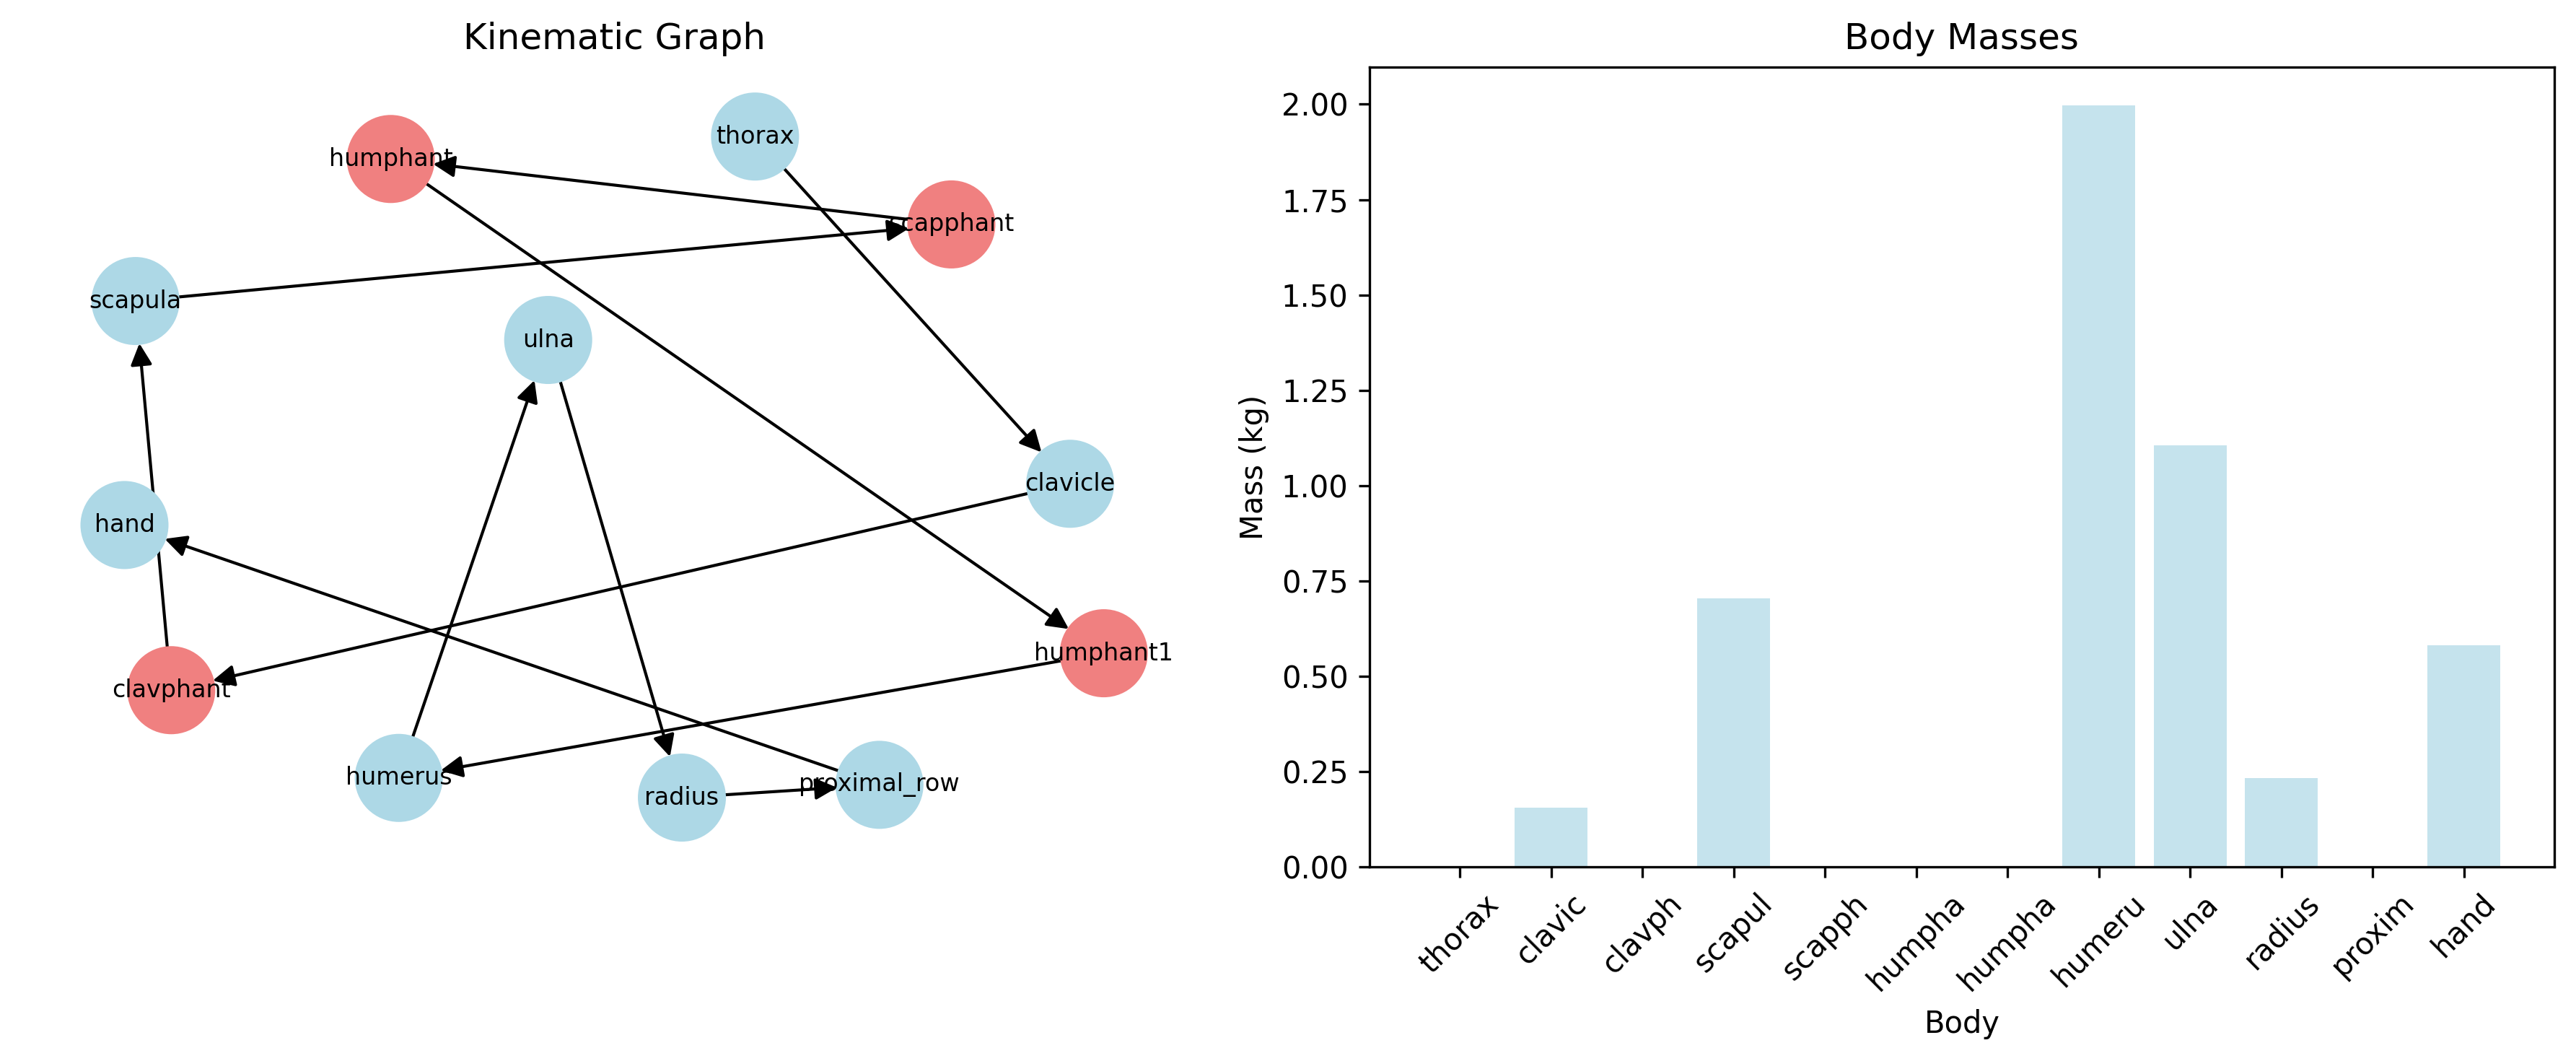

In [87]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Color coding
node_colors = ['lightcoral' if 'phant' in name.lower() else 'lightblue' for name in body_names]

# Graph layouts
pos1 = nx.spring_layout(G, k=2, iterations=50, seed=42)
nx.draw(G, pos1, ax=ax1, with_labels=True, node_color=node_colors, 
        node_size=800, font_size=8, arrows=True, arrowsize=15)
ax1.set_title("Kinematic Graph")

# Mass distribution
masses = node_features[:, 0].numpy()
ax2.bar(range(len(body_names)), masses, color=node_colors, alpha=0.7)
ax2.set_xlabel('Body')
ax2.set_ylabel('Mass (kg)')
ax2.set_title('Body Masses')
ax2.set_xticks(range(len(body_names)))
ax2.set_xticklabels([name[:6] for name in body_names], rotation=45)

plt.tight_layout()
plt.show()

In [88]:
# Summary
print("ANALYSIS SUMMARY")
print("=" * 30)
print(f"Model: MOBL Arms 4.1 ({total_mass:.2f} kg total)")
print(f"Structure: {len(body_names)} bodies, {edge_index.shape[1]} joints")
print(f"DOF: {n_coordinates} coordinates across {n_joints} joints")
print(f"Muscles: {len(muscle_names)} total")
print(f"Graph: Connected tree with {G.number_of_nodes()} nodes")
print(f"Features: 3D node features (mass, position, type)")
print()
print("Model suitable for:")
print("• Upper extremity biomechanics research")  
print("• Graph neural network training")
print("• Kinematic analysis and simulation")

ANALYSIS SUMMARY
Model: MOBL Arms 4.1 (4.78 kg total)
Structure: 12 bodies, 11 joints
DOF: 26 coordinates across 12 joints
Muscles: 50 total
Graph: Connected tree with 12 nodes
Features: 3D node features (mass, position, type)

Model suitable for:
• Upper extremity biomechanics research
• Graph neural network training
• Kinematic analysis and simulation
